<a href="https://colab.research.google.com/github/platers/meta-transfer-learning/blob/master/reward_generalize_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook measures how well learned reward functions generalize to new environments.
It trains a reward function on a series of environments with different colors for the agent and background. It measures how well the reward function can generalize to colors it hasn't seen before.

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

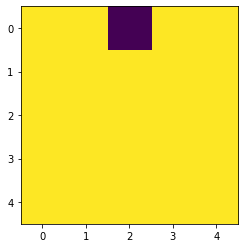

In [2]:
class TransferTestEnv(gym.Env):
  """Makes an environment with one color for the agent and another color for the background.
  Generates the agent in a random position each reset.
  Returns the reward based on how close the agent is to the top right.
  """
  def __init__(self, bg_color, agent_color):
    self.bg_color = bg_color
    self.agent_color = agent_color
    self.color_num = 1
    self.env_size = 5
    pass

  def reset(self):
    self.location = np.random.randint(0, self.env_size, [2])
    color_extra_dim = np.reshape(self.bg_color, [1,1,self.color_num])
    state = np.tile(color_extra_dim, [self.env_size, self.env_size, self.color_num])

    state[self.location[0], self.location[1]] = self.agent_color

    reward = self.location[0] + self.location[1]

    return state, reward

state, reward = TransferTestEnv(5, 1).reset()
plt.imshow(np.squeeze(state))


In [0]:
def generate_data(dataset_size, env_params_list):
  """Generates data by randomly sampling from environments with the specified parameters.""" 
  xs = []
  ys = []
  for _ in range(dataset_size):
    env_params = random.choice(env_params_list)
    state, reward = TransferTestEnv(*env_params).reset()
    xs.append(state)
    ys.append(reward)

  xs = np.array(xs)
  ys = np.array(ys)

  return xs, ys

In [4]:
# Creates parameters with different background and foreground colors. Make sure that the colors are different enough

max_num_envs = 30

while True:
  train_env_params = np.random.random(size=(max_num_envs, 2))
  diff = np.abs(train_env_params[:, 0] - train_env_params[:, 1])

  if np.min(diff) > .2:
    break

print(train_env_params)

[[0.91580422 0.37267882]
 [0.51871887 0.17071641]
 [0.90882902 0.08942645]
 [0.02328206 0.69627814]
 [0.04563108 0.74976349]
 [0.31875623 0.06522083]
 [0.87832193 0.39448741]
 [0.70523991 0.03077746]
 [0.98436063 0.2020689 ]
 [0.54993953 0.23148112]
 [0.69078435 0.04299349]
 [0.18065147 0.66022619]
 [0.86975427 0.39885421]
 [0.12782681 0.80001233]
 [0.21200446 0.5622773 ]
 [0.42740758 0.79395588]
 [0.25105368 0.7629112 ]
 [0.25122031 0.87086195]
 [0.94539916 0.71482778]
 [0.20626812 0.70820788]
 [0.89907387 0.32248161]
 [0.48148443 0.16506207]
 [0.17679271 0.53772512]
 [0.18345035 0.65676078]
 [0.40372076 0.17509311]
 [0.43734278 0.90589115]
 [0.27882546 0.85439287]
 [0.11719427 0.87992608]
 [0.2431353  0.92170882]
 [0.54650957 0.09027126]]


In [0]:
def get_generalization_amount(train_env_params):
  xs, ys = generate_data(1000, train_env_params)
  print("train_env_params", train_env_params)

  #Model architecture
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=xs.shape[1:]),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
  ])
  model.compile(optimizer='adam', loss='mse')
  # Train the model on the data.
  model.fit(xs, ys, epochs=400, verbose=0)

  xs_val, ys_val = generate_data(1000, train_env_params)
  xs_val_differnt, ys_val_different = generate_data(1000, [(1.1, -.1)])

  model.evaluate(xs, ys)
  # This is the loss from different data on the same environments.
  val_loss = model.evaluate(xs_val, ys_val)
  # This is the loss from different data on different environments.
  different_loss = model.evaluate(xs_val_differnt, ys_val_different)

  return val_loss, different_loss

In [6]:
# Get the val and generalization losses using different numbers of environments.
gaps_for_nums = []
num_envs_ar = list(range(1, max_num_envs))
val_loss_ar = []
different_loss_ar = []
for num_envs in num_envs_ar:
  val_loss, different_loss = get_generalization_amount(train_env_params[:num_envs])

  val_loss_ar.append(val_loss)
  different_loss_ar.append(different_loss)

  print([num_envs, val_loss, different_loss])

val_loss_ar = np.array(val_loss_ar)
different_loss_ar = np.array(different_loss_ar)

train_env_params [[0.91580422 0.37267882]]
32/32 [==============================] - 0s 1ms/step - loss: 6.2876
[1, 7.980282680364326e-05, 6.2875657081604]
train_env_params [[0.91580422 0.37267882]
 [0.51871887 0.17071641]]
32/32 [==============================] - 0s 1ms/step - loss: 8.6591
[2, 0.010952015407383442, 8.659147262573242]
train_env_params [[0.91580422 0.37267882]
 [0.51871887 0.17071641]
 [0.90882902 0.08942645]]
32/32 [==============================] - 0s 1ms/step - loss: 2.3927
[3, 0.2089225947856903, 2.3927316665649414]
train_env_params [[0.91580422 0.37267882]
 [0.51871887 0.17071641]
 [0.90882902 0.08942645]
 [0.02328206 0.69627814]]
32/32 [==============================] - 0s 1ms/step - loss: 1.3617
[4, 0.11780652403831482, 1.3616830110549927]
train_env_params [[0.91580422 0.37267882]
 [0.51871887 0.17071641]
 [0.90882902 0.08942645]
 [0.02328206 0.69627814]
 [0.04563108 0.74976349]]
32/32 [==============================] - 0s 1ms/step - loss: 1.8310
[5, 0.12729340791

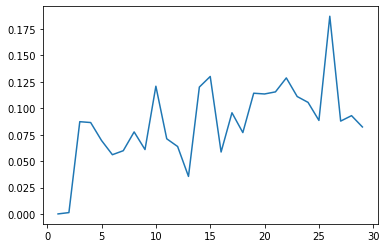

In [7]:
gaps = val_loss_ar / different_loss_ar
# Plot the ratio of loss on the data from the same environments vs different environments. Higher is better.
# X axis is the number of training environments.
plt.plot(num_envs_ar, gaps)

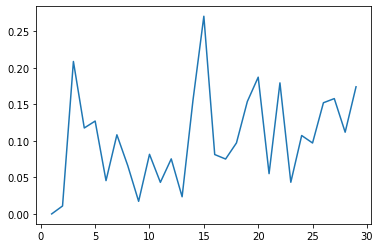

In [8]:
plt.plot(num_envs_ar, val_loss_ar)

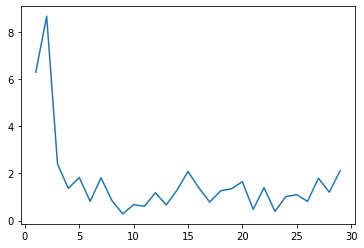

In [9]:
plt.plot(num_envs_ar, different_loss_ar)